# Моделирование времен прихода

## Реализация

In [ ]:
# Файл model_toa.py


import numpy as np
import matplotlib.pyplot as plt


class ModelTOA:
    def __init__(
        self,
        T: int,
        std_toa: float,
        time_start_jitter: float,
        signal_loss_rate: float,
        min_period: float,
        max_period: float,
        period_num: int,
        period_diff_threshold: float,
    ) -> None:
        """Класс моделирования времен прихода.

        Args:
            T (int): Длительность каждой пачки.
            std_toa (float): СКО времен прихода.
            time_start_jitter (float): Максимальный случайный сдвиг каждой пачки (равномерное распределение от 0 до этого значения).
            signal_loss_rate (float): Процент потерь сигналов.
            min_period (float): Минимальный период следования.
            max_period (float): Маскимальный период следования.
            period_num (int): Количество различных периодов следования (число источников).
            period_diff_threshold (int): Пороговое значение для разницы между периодами (разрешающая способность).
        """
        self.__T = T
        self.__std_toa = std_toa
        self.__time_start_jitter = time_start_jitter
        self.__signal_loss_rate = signal_loss_rate
        self.__period_diff_threshold = period_diff_threshold
        self.__period_array = self.__generate_unique_periods(
            min_period, max_period, period_num
        )

        self._toa_array = np.array([])
        self._labels = np.array([])
        self._sequence_lens = {}

    def __generate_unique_periods(
        self, min_period: float, max_period: float, period_num: int
    ) -> np.ndarray:
        periods = np.zeros(period_num)
        for i in range(period_num):
            while True:
                period = np.random.uniform(min_period, max_period)
                if all(abs(period - periods[:i]) > self.__period_diff_threshold):
                    periods[i] = period
                    break
        return np.sort(periods)

    def generate_toa(self) -> None:
        for i, period in enumerate(self.__period_array):
            time_arrival = np.arange(0, self.__T, period) + np.random.uniform(
                0, self.__time_start_jitter, 1
            )
            time_arrival += np.random.normal(0, self.__std_toa, len(time_arrival))

            mask = np.random.uniform(size=len(time_arrival)) >= self.__signal_loss_rate

            time_arrival = time_arrival[mask]
            label = np.ones(len(time_arrival)) * i
            self._labels = np.concatenate([self._labels, label])

            self._sequence_lens[i] = len(time_arrival)
            self._toa_array = np.concatenate([self._toa_array, time_arrival])

        self._labels = self._labels[np.argsort(self._toa_array)]
        self._toa_array = np.sort(self._toa_array)
        self._toa_array -= min(self._toa_array)

    def get_labels(self) -> np.ndarray:
        return self._labels

    def get_toa_array(self) -> np.ndarray:
        return self._toa_array

    def get_period_array(self) -> np.ndarray:
        return self.__period_array

    def get_std_toa(self) -> float:
        return self.__std_toa

    def get_T(self) -> int:
        return self.__T

    def get_signal_loss_rate(self) -> float:
        return self.__signal_loss_rate

    def draw_scatter_plot(self, start: int, end: int) -> None:
        plt.title("Диаграмма рассеяния времен прихода")
        plt.ylabel("Время прихода, с")
        plt.xlabel("Число отсчетов")

        unique_labels = np.unique(self._labels[start:end])
        colors = plt.get_cmap("viridis", len(unique_labels))(
            np.arange(len(unique_labels))
        )

        scatter = plt.scatter(
            x=np.arange(len(self._toa_array))[start:end],
            y=self._toa_array[start:end],
            c=self._labels[start:end],
            cmap="viridis",
        )

        legend_elements = [
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=colors[i],
                markersize=10,
                label=f"Период {int(label)}",
            )
            for i, label in enumerate(unique_labels)
        ]
        plt.legend(handles=legend_elements, title="Периоды")

        plt.grid()
        plt.show()

## Использование

In [ ]:
model_toa = ModelTOA(T=4,
                     std_toa=1e-6,
                     time_start_jitter=1e-2,
                     signal_loss_rate=0.3,
                     min_period=1e-3,
                     max_period=10e-3,
                     period_num=5,
                     period_diff_threshold=5e-5)
model_toa.generate_toa()

In [ ]:
print(model_toa.get_labels())
print(model_toa.get_toa_array())
print(model_toa.get_period_array())

[3. 2. 0. ... 2. 4. 1.]
[0.00000000e+00 5.82122675e-04 3.44751795e-03 ... 3.99973363e+00
 4.00016919e+00 4.00081080e+00]
[0.00479926 0.00510477 0.00526898 0.00634206 0.00780914]


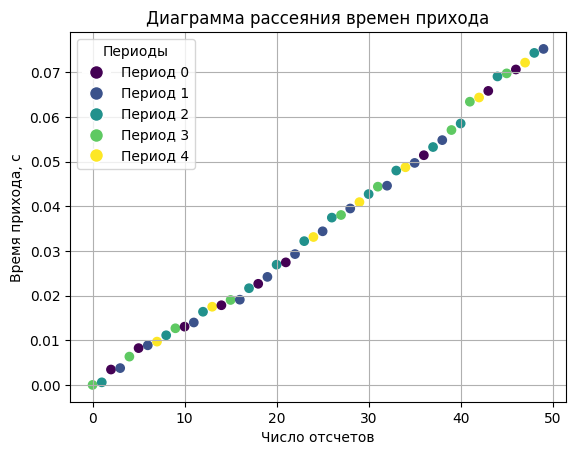

In [ ]:
model_toa.draw_scatter_plot(0, 50)

# Обзор алгоритмов оценки количества источников по временам прихода

## Получение данных от модели

In [ ]:
toa_array = model_toa.get_toa_array()
period_array = model_toa.get_period_array()
T = model_toa.get_T()
signal_loss_rate = model_toa.get_signal_loss_rate()
std_toa = model_toa.get_std_toa()

## Расчет матрицы разностей

In [ ]:
# пороги по возможным периодам
min_period_threshold = 0.05e-3
max_period_threshold = 20e-3

In [ ]:
diff_matrix = (toa_array - toa_array.reshape(-1,1))

diff_matrix[diff_matrix <= min_period_threshold] = -100
diff_matrix[diff_matrix >= max_period_threshold] = -100

phase_matrix = np.exp(1j * 2 * np.pi * (toa_array % diff_matrix) / diff_matrix)

diff = diff_matrix.flatten()
phase = phase_matrix.flatten()

diff_index = np.argwhere(diff > 0)
phase = phase[diff>0]
diff = diff[diff>0]
diff.shape

(32088,)

## Функция порогов PRI для гистограмм

In [ ]:
def get_thresholds(periods: np.ndarray, T: int, hist_n: np.ndarray, signal_loss_rate: float, x: float, g: float):
    N = T * np.sum(1 / periods)
    B = len(hist_n)
    d = np.max(hist_n) - np.mean(hist_n)
    x *= signal_loss_rate
    thresholds = [x * (N - d) * np.exp(-period / g * B) for period in periods]
    return np.array(thresholds)

## Delta-T гистограмма

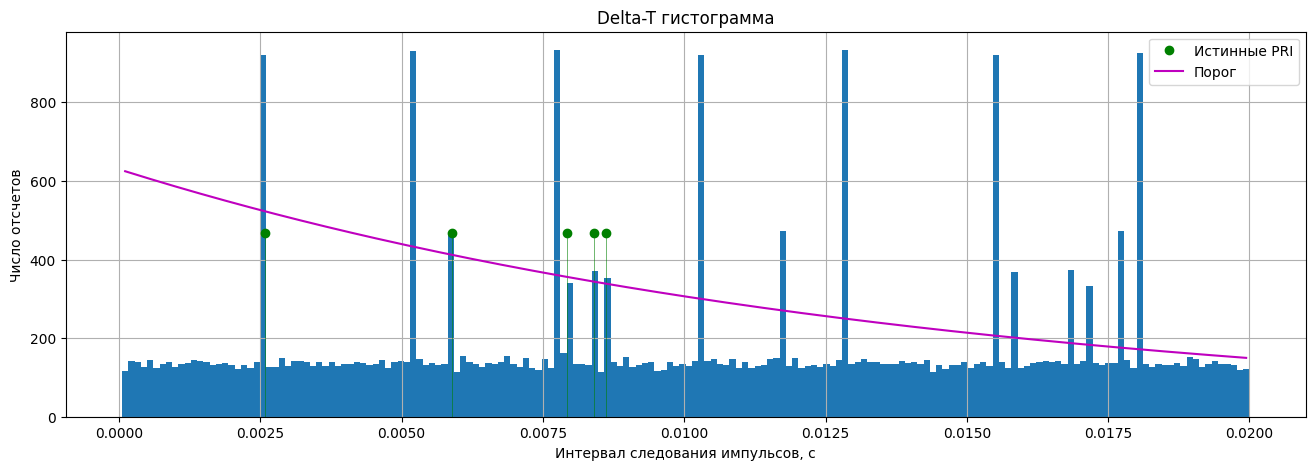

In [ ]:
plt.figure(figsize=(16,5))
hist_res = plt.hist(diff, bins = 'sqrt')

edges = hist_res[1]
mid_bins = (edges[1:] + edges[:-1]) / 2

thresholds = get_thresholds(periods=mid_bins,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=1e-2,
                            g=2.5)

plt.plot(period_array, [max(hist_res[0])*0.5] * len(period_array), 'go', label="Истинные PRI")
plt.vlines(period_array, 0, max(hist_res[0])*0.5, 'g', linewidth=0.4)
plt.plot(mid_bins, thresholds, color='m', label='Порог')

plt.title('Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Комплексная Delta-T гистограмма

In [ ]:
bin_edges = hist_res[1]
mid_bins = (bin_edges[:-1] + bin_edges[1:]) / 2
count = np.zeros(len(bin_edges), dtype = 'complex')
for ph, val in zip(phase, diff):
    ind = np.searchsorted(bin_edges, val, side='right') - 1
    count[ind] += ph
complex_amplitude = abs(count)

In [ ]:
thresholds = get_thresholds(periods=mid_bins,
                            T=T,
                            hist_n=hist_res[0],
                            signal_loss_rate=signal_loss_rate,
                            x=1e-3,
                            g=15)

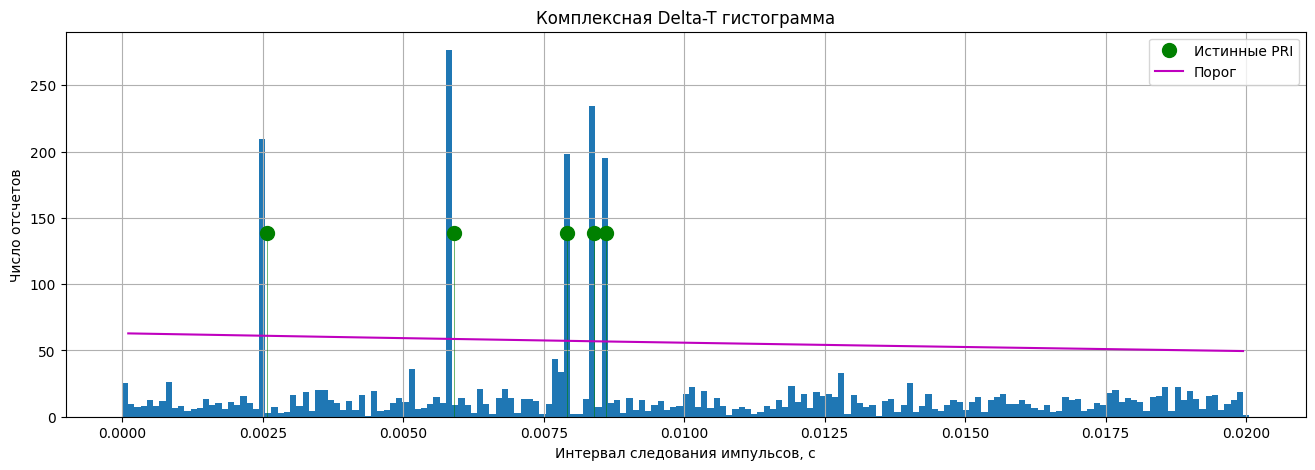

In [ ]:
plt.figure(figsize=(16,5))

plt.bar(bin_edges, complex_amplitude, width=bin_edges[1]-bin_edges[0])
plt.plot(period_array, [max(complex_amplitude)*0.5] * len(period_array), 'go', markersize=10, label="Истинные PRI")
plt.vlines(period_array, 0, max(complex_amplitude)*0.5, 'g', linewidth=0.4)
plt.plot(mid_bins, thresholds, color='m', label='Порог')

plt.title('Комплексная Delta-T гистограмма')
plt.xlabel('Интервал следования импульсов, с')
plt.ylabel('Число отсчетов')
plt.grid()
plt.legend()
plt.show()

## Быстрое преобразованием Фурье с временным кодированием

In [ ]:
from tqdm import tqdm

delta_t = 1e-6 # разрешение по времени

signal = np.zeros(int(max(toa_array) / delta_t)+2)
time_array = np.arange(0, max(toa_array)+delta_t, delta_t)

for toa in tqdm(toa_array):
    signal[np.searchsorted(time_array, toa, side='right')] = 1

print(f'\ntoa len: {len(toa_array)}')
print(f'time coding signal len: {len(signal)}')

100%|██████████| 2580/2580 [00:00<00:00, 87778.26it/s]


toa len: 2580
time coding signal len: 4002808


In [ ]:
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), delta_t)
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]
fs = 1 / delta_t
N = int((2 * len(amplitude)) / (fs * min_period_threshold) / 16)

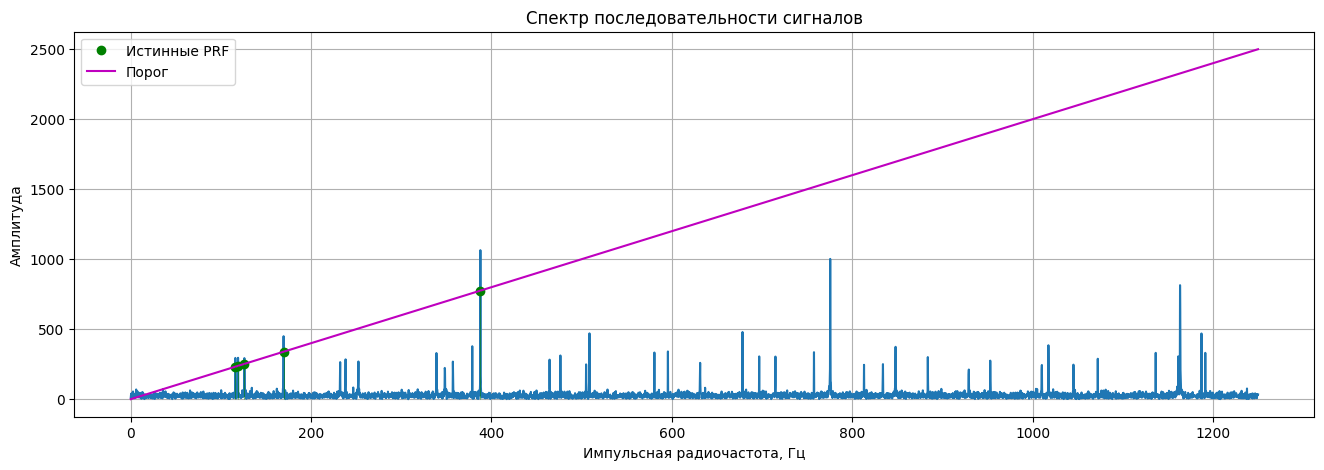

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies[1:N], amplitude[1:N])
plt.plot(1 / period_array, (T / period_array)*0.5, 'go', label="Истинные PRF")
plt.plot(frequencies[1:N], (T * frequencies[1:N])*0.5, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Прямое быстрое преобразование Фурье

In [ ]:
signal_1 = np.sin(2 * np.pi * (toa_array) / (max(toa_array)))

n_fft = 2 ** int(np.ceil(np.log2(len(toa_array))))

fft_result = np.fft.fft(signal_1, n_fft)
frequencies = np.fft.fftfreq(n_fft, (max(toa_array)/(len(toa_array))))
amplitude = np.abs(fft_result)
frequencies = frequencies[:len(frequencies)//2]
amplitude = amplitude[:len(amplitude)//2]

Nmin = int(n_fft*0.02)
Nmax = -1

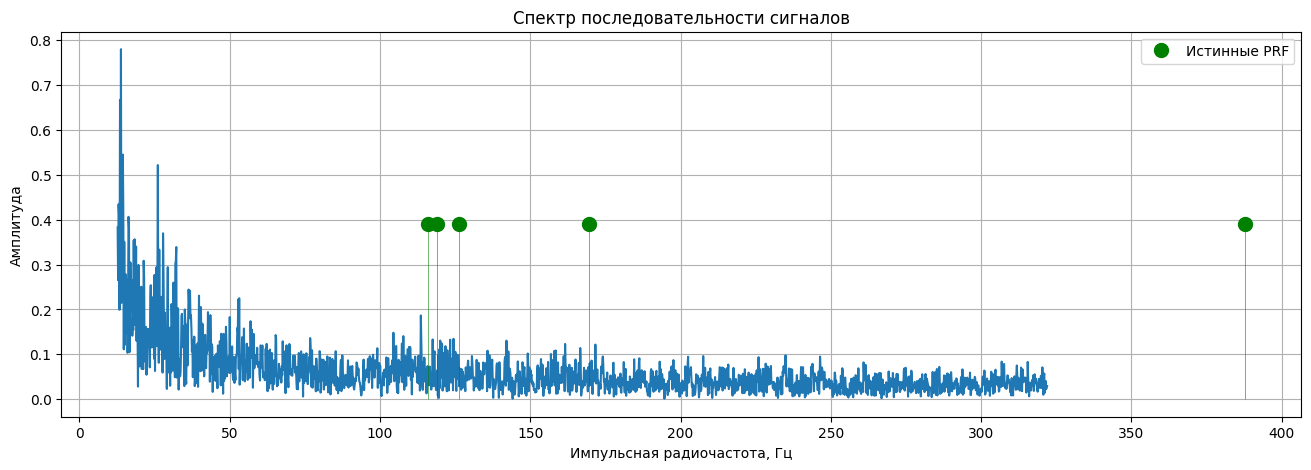

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies[Nmin:Nmax], amplitude[Nmin:Nmax])

plt.plot(1 / period_array, [max(amplitude[Nmin:Nmax])*0.5] * len(period_array), 'go', markersize=10, label="Истинные PRF")
plt.vlines(1 / period_array, 0, max(amplitude[Nmin:Nmax])*0.5, 'g', linewidth=0.4)
plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

## Дельта-функция с прямым преобразованием Фурье

In [ ]:
min_freq = 50
max_freq = 1000
frequencies = np.log(np.linspace(np.exp(min_freq/max_freq), np.exp(1), num = 8000)) / np.log(5) * max_freq

amplitude = np.exp(-1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
amplitude = np.abs(np.sum(amplitude, axis=0))

alpha = 0.5

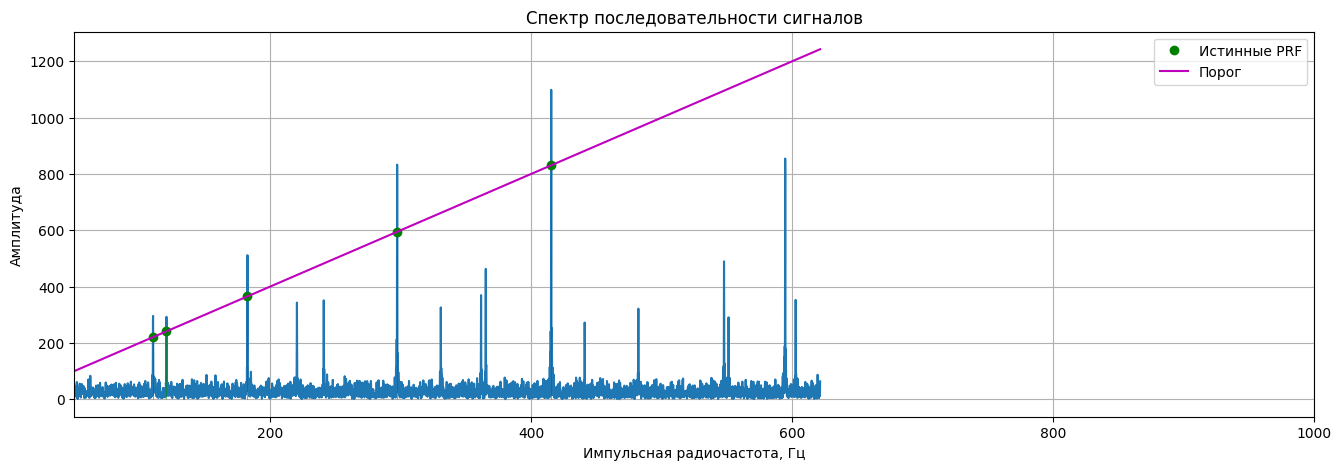

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies, amplitude)
plt.plot(1 / period_array, (T / period_array)*alpha, 'go', label="Истинные PRF")
plt.plot(frequencies, (T * frequencies)*alpha, 'm', label="Порог")
plt.vlines(1 / period_array, 0, (T / period_array)*0.5, 'g', linewidth=0.4)

plt.xlim(min_freq, max_freq)
plt.title('Спектр последовательности сигналов')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

In [ ]:
PRF = frequencies[amplitude > (T * frequencies)*alpha]
amp = amplitude[amplitude > (T * frequencies)*alpha]
est_PRF = np.sort(PRF[np.argsort(amp)])
est_PRF

array([116.15497468, 119.11935112, 126.30841608, 169.62211712,
       387.7781076 ])

# Функция устранения дубликатов найденных периодов следования

## Рассчёт PRF

In [ ]:
min_freq = 50
max_freq = 1000
frequencies = np.log(np.linspace(np.exp(min_freq/max_freq), np.exp(1), num = 15000)) * max_freq

amplitude = np.exp(1j * 2 * np.pi * frequencies * toa_array.reshape(-1,1))
amplitude = np.abs(np.sum(amplitude, axis=0))

alpha = 0.5

PRF = frequencies[amplitude > (T * frequencies)*alpha]
amp = amplitude[amplitude > (T * frequencies)*alpha]
est_PRF = np.sort(PRF[np.argsort(amp)])
est_PRF

array([116.06465199, 116.16360941, 119.02912309, 119.12778761,
       126.2061711 , 126.30413006, 169.53345962, 169.62726511,
       387.71424811, 387.78966656, 387.86507931])

## Реализация

In [ ]:
def average_estimated_PRF(estimated_PRF: np.ndarray, averaging_threshold: float) -> np.ndarray:
    sorted_PRF = np.sort(estimated_PRF)

    grouped_PRF = []
    current_group = [sorted_PRF[0]]

    for i in range(1, len(sorted_PRF)):
        if abs(sorted_PRF[i] - sorted_PRF[i - 1]) < averaging_threshold:
            current_group.append(sorted_PRF[i])
        else:
            grouped_PRF.append(np.mean(current_group))
            current_group = [sorted_PRF[i]]

    grouped_PRF.append(np.mean(current_group))

    return np.array(grouped_PRF)

## Использование

In [ ]:
averaged_PRF = average_estimated_PRF(estimated_PRF=est_PRF, averaging_threshold=5e-1)
print(averaged_PRF)
print(np.sort(1 / period_array))

[116.1141307  119.07845535 126.25515058 169.58036236 387.78966466]
[116.1241807  119.11598002 126.24153708 169.56073687 387.7623713 ]


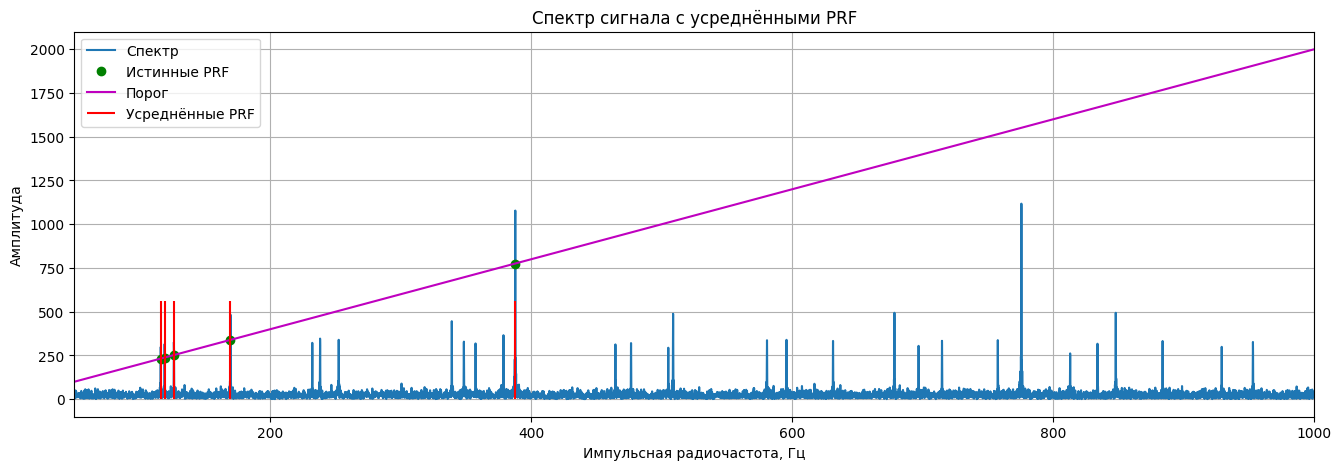

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(frequencies, amplitude, label='Спектр')
plt.plot(1 / period_array, (T / period_array)*alpha, 'go', label='Истинные PRF')
plt.plot(frequencies, (T * frequencies)*alpha, 'm', label='Порог')
plt.vlines(averaged_PRF, 0, max(amplitude)*0.5, 'r', linewidth=1.5, label='Усреднённые PRF')

plt.xlim(min_freq, max_freq)
plt.title('Спектр сигнала с усреднёнными PRF')
plt.xlabel('Импульсная радиочастота, Гц')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
plt.show()

In [ ]:
PRI = np.sort(1 / averaged_PRF)

print(PRI)
print(np.sort(period_array))

[0.00257872 0.00589691 0.00792047 0.00839782 0.00861222]
[0.0025789  0.00589759 0.00792132 0.00839518 0.00861147]


# Программный модуль

## Получение данных от модели

In [ ]:
toa_array = model_toa.get_toa_array()
period_array = model_toa.get_period_array()
T = model_toa.get_T()
signal_loss_rate = model_toa.get_signal_loss_rate()
std_toa = model_toa.get_std_toa()

## Реализация

In [ ]:
# Файл parametric_signal_selector.py


from enum import Enum
import numpy as np
import matplotlib.pyplot as plt


class FrequencyGridMode(Enum):
    LINEAR = "linear"
    LOG = "log"
    NOMINAL = "nominal"


class ParametricSignalSelector:
    def __init__(
        self,
        T: int,
        alpha_threshold: float,
        averaging_threshold: float,
        min_freq: int = None,
        max_freq: int = None,
        freqs: list[float] = None,
        freq_step: float = None,
        freq_count: int = None,
    ) -> None:
        """Класс параметрической селекции сигналов.

        Args:
            T (int): Длительность пачки.
            alpha_threshold (float): Порог обнаружения PRF.
            averaging_threshold (float): Порог усреднения PRF.
            min_freq (int): Минимальная частота.
            max_freq (int): Максимальная частота.
            freqs (list[float]): Номиналы частот.
            freq_step (float): Шаг сетки.
            freq_count (int): Количество точек в сетке.
        """
        self._T = T
        self._alpha = alpha_threshold
        self._averaging_threshold = averaging_threshold
        self._grid_params = {
            "min_freq": min_freq,
            "max_freq": max_freq,
            "freqs": freqs,
            "freq_step": freq_step,
            "freq_count": freq_count,
        }

    def __generate_linear_freq(self) -> np.ndarray:
        return np.arange(
            self._grid_params["min_freq"],
            self._grid_params["max_freq"],
            self._grid_params["freq_step"],
        )

    def __generate_log_freq(self) -> np.ndarray:
        return (
            np.log(
                np.linspace(
                    np.exp(
                        self._grid_params["min_freq"] / self._grid_params["max_freq"]
                    ),
                    np.exp(1),
                    num=self._grid_params["freq_count"],
                )
            )
            * self._grid_params["max_freq"]
        )

    def __get_frequencies(self, mode: FrequencyGridMode) -> np.ndarray:
        if mode == FrequencyGridMode.LINEAR:
            return self.__generate_linear_freq()
        elif mode == FrequencyGridMode.LOG:
            return self.__generate_log_freq()
        elif mode == FrequencyGridMode.NOMINAL:
            return np.array(self._grid_params["freqs"])
        else:
            raise ValueError("Неподдерживаемый режим сетки")

    def __calculate_amplitude(
        self, frequencies: np.ndarray, toa_array: np.ndarray
    ) -> np.ndarray:
        amplitude = np.exp(1j * 2 * np.pi * frequencies * toa_array.reshape(-1, 1))
        amplitude = np.abs(np.sum(amplitude, axis=0))
        return amplitude

    def _estimate_PRF(
        self, toa_array: np.ndarray, mode: FrequencyGridMode
    ) -> np.ndarray:
        frequencies = self.__get_frequencies(mode)
        amplitude = self.__calculate_amplitude(frequencies, toa_array)

        PRF = frequencies[amplitude > (self._T * frequencies) * self._alpha]
        amp = amplitude[amplitude > (self._T * frequencies) * self._alpha]
        est_PRF = np.sort(PRF[np.argsort(amp)])
        return est_PRF

    def _average_estimated_PRF(self, estimated_PRF: np.ndarray) -> np.ndarray:
        averaged_PRF = []

        if not estimated_PRF.size > 0:
            return np.array(averaged_PRF)

        sorted_PRF = np.sort(estimated_PRF)
        current_group = [sorted_PRF[0]]

        for i in range(1, len(sorted_PRF)):
            if abs(sorted_PRF[i] - sorted_PRF[i - 1]) < self._averaging_threshold:
                current_group.append(sorted_PRF[i])
            else:
                averaged_PRF.append(np.mean(current_group))
                current_group = [sorted_PRF[i]]

        averaged_PRF.append(np.mean(current_group))

        return np.array(averaged_PRF)

    def estimate_PRI(
        self, toa_array: np.ndarray, mode: FrequencyGridMode
    ) -> np.ndarray:
        estimated_PRF = self._estimate_PRF(toa_array, mode)
        averaged_PRF = self._average_estimated_PRF(estimated_PRF)
        return np.sort(1 / averaged_PRF)

    def plot_signal_spectrum(
        self, period_array: np.ndarray, toa_array: np.ndarray, mode: FrequencyGridMode
    ) -> None:
        frequencies = self.__get_frequencies(mode)
        amplitude = self.__calculate_amplitude(frequencies, toa_array)
        estimated_PRF = self._estimate_PRF(toa_array, mode)
        averaged_PRF = self._average_estimated_PRF(estimated_PRF)

        plt.figure(figsize=(16, 5))
        plt.plot(frequencies, amplitude, label="Спектр")
        plt.plot(
            1 / period_array,
            (self._T / period_array) * self._alpha,
            "go",
            label="Истинные PRF",
        )
        plt.plot(frequencies, (self._T * frequencies) * self._alpha, "m", label="Порог")
        plt.vlines(
            averaged_PRF,
            0,
            max(amplitude) * 0.5,
            "r",
            linewidth=1.5,
            label="Обнаруженные PRF",
        )

        plt.xlim(self._grid_params["min_freq"], self._grid_params["max_freq"])
        plt.title("Спектр последовательности сигналов с обнаруженными PRF")
        plt.xlabel("Импульсная радиочастота, Гц")
        plt.ylabel("Амплитуда")
        plt.grid()
        plt.legend()
        plt.show()

## Использование

### С использование линейной частотной сетки

In [ ]:
parametric_signal_selector = ParametricSignalSelector(T=T,
                                                      min_freq=50,
                                                      max_freq=1000,
                                                      alpha_threshold=5e-1,
                                                      averaging_threshold=5e-1,
                                                      freq_step=1e-1)

In [ ]:
PRI_linear = parametric_signal_selector.estimate_PRI(toa_array=toa_array, mode=FrequencyGridMode.LINEAR)
print(PRI_linear)
print(np.sort(period_array))

[0.00479962 0.00510595 0.00527009 0.00634317 0.00780945]
[0.00479926 0.00510477 0.00526898 0.00634206 0.00780914]


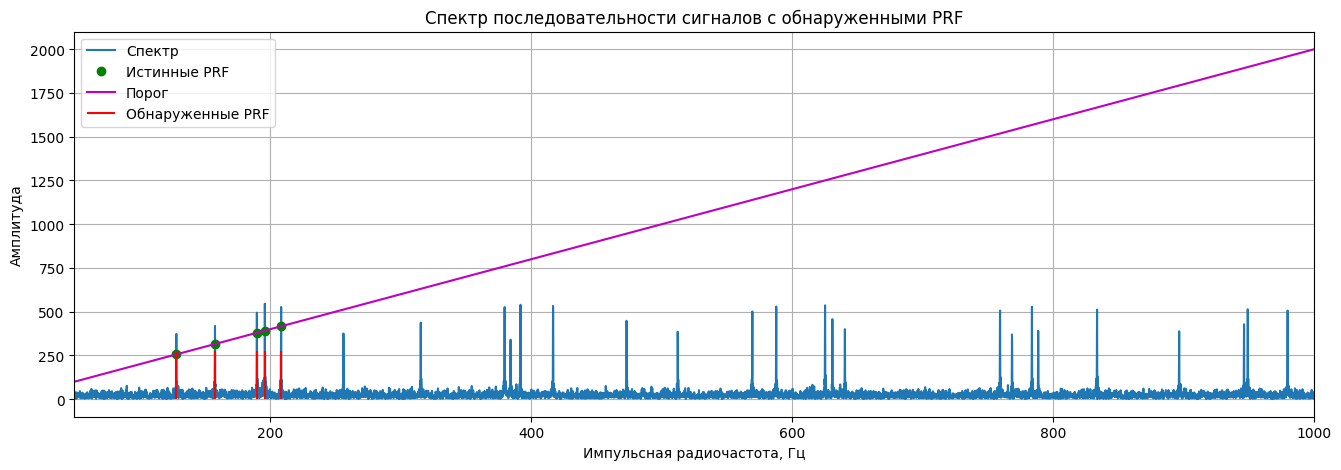

In [ ]:
parametric_signal_selector.plot_signal_spectrum(
    period_array=period_array,
    toa_array=toa_array,
    mode=FrequencyGridMode.LINEAR
)

### С использование логарифической частотной сетки

In [ ]:
parametric_signal_selector = ParametricSignalSelector(T=T,
                                                      min_freq=50,
                                                      max_freq=1000,
                                                      alpha_threshold=5e-1,
                                                      averaging_threshold=5e-1,
                                                      freq_count=8000)

In [ ]:
PRI_log = parametric_signal_selector.estimate_PRI(toa_array, mode=FrequencyGridMode.LOG)
print(PRI_log)
print(np.sort(period_array))

[0.00479768 0.00510635 0.00526815 0.00634201 0.00780934]
[0.00479926 0.00510477 0.00526898 0.00634206 0.00780914]


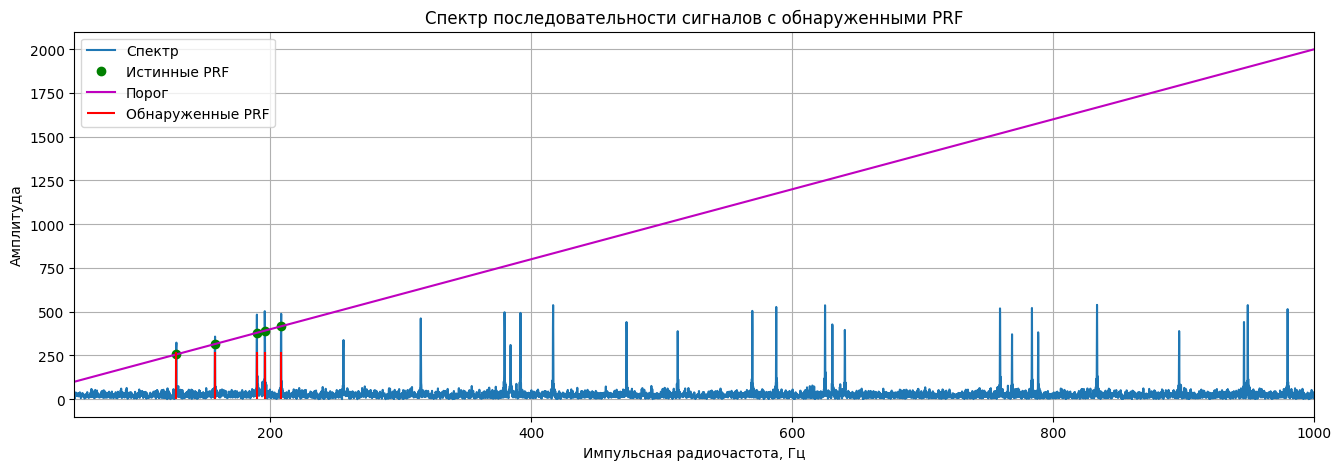

In [ ]:
parametric_signal_selector.plot_signal_spectrum(
    period_array=period_array,
    toa_array=toa_array,
    mode=FrequencyGridMode.LOG
)

### С использованием номиналов PRF

In [ ]:
goal_nominals_PRF = np.sort(1 / period_array)
other_nominals_PRF = np.array(list(map(int, np.linspace(50, 1000, 200-len(goal_nominals_PRF)))))
completed_nominals_PRF = np.sort(np.concat((goal_nominals_PRF, other_nominals_PRF)))

parametric_signal_selector = ParametricSignalSelector(T=T,
                                                      min_freq=50,
                                                      max_freq=1000,
                                                      alpha_threshold=5e-1,
                                                      averaging_threshold=5e-1,
                                                      freqs=completed_nominals_PRF)

In [ ]:
PRI_nominals = parametric_signal_selector.estimate_PRI(toa_array, mode=FrequencyGridMode.NOMINAL)
print(PRI_nominals)
print(np.sort(period_array))

[0.00479926 0.00510477 0.00526898 0.00634206 0.00781082]
[0.00479926 0.00510477 0.00526898 0.00634206 0.00780914]


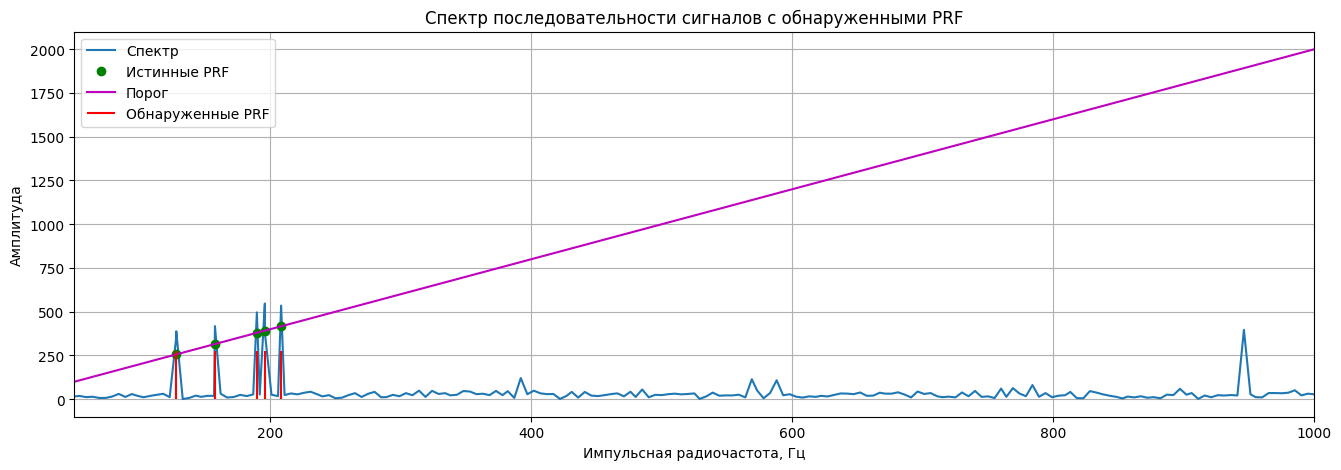

In [ ]:
parametric_signal_selector.plot_signal_spectrum(
    period_array=period_array,
    toa_array=toa_array,
    mode=FrequencyGridMode.NOMINAL
)

# Функция метрики


## Реализация

In [ ]:
# Файл metric.py

import numpy as np


def quality_metric(reference_PRI: np.ndarray, estimated_PRI: np.ndarray) -> float:
    """Используется расстояние Хаусдорффа для одномерных массивов"""
    directed_hausdorff_1d = lambda set1, set2: np.max(
        [np.min([np.abs(x - y) for y in set2]) for x in set1]
    )
    d1 = directed_hausdorff_1d(reference_PRI, estimated_PRI)
    d2 = directed_hausdorff_1d(estimated_PRI, reference_PRI)
    return max(d1, d2)

## Использование

### Линейная частотная сетка

In [ ]:
print(quality_metric(period_array, PRI_linear))

1.6404224224084857e-06


### Логарифмическая частотная сетка

In [ ]:
print(quality_metric(period_array, PRI_log))

4.125471969755601e-06


### Частотная сетка с номиналами PRF

In [ ]:
print(quality_metric(period_array, PRI_nominals))

8.673617379884035e-19


### Примеры расчета в микросекундах

In [ ]:
ref_PRI = [100, 200, 300]
est_PRI = [101, 205, 306]
res = quality_metric(ref_PRI, est_PRI)
print(res)

6


In [ ]:
ref_PRI = [120, 250, 310]
est_PRI = [121, 253, 300]
print(quality_metric(ref_PRI, est_PRI))

10


In [ ]:
ref_PRI = [500, 800, 930]
est_PRI = [505, 810]
res = quality_metric(ref_PRI, est_PRI)
print(res)

120


# Пайплайн для вариьрования параметров и оценки по метрике

In [ ]:
!pip install scikit-optimize

In [ ]:
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
# from modules.model_toa import ModelTOA
# from modules.parametric_signal_selection import (
#     ParametricSignalSelector,
#     FrequencyGridMode,
# )
# from modules.metric import quality_metric


def evaluate_selector_params(
    alpha_threshold: float,
    averaging_threshold: float,
    freq_step: float,
    model_params: dict,
) -> float:
    """Вычисление метрики качества для заданных параметров"""
    model = ModelTOA(**model_params)
    model.generate_toa()
    reference_PRI = model.get_period_array()

    if len(reference_PRI) == 0:
        return 10 ** 6

    min_freq = 1 / np.max(reference_PRI)
    max_freq = 1 / np.min(reference_PRI)

    selector = ParametricSignalSelector(
        T=model_params["T"],
        alpha_threshold=alpha_threshold,
        averaging_threshold=averaging_threshold,
        min_freq=min_freq,
        max_freq=max_freq,
        freq_step=freq_step,
    )

    try:
        estimated_PRI = selector.estimate_PRI(
            model.get_toa_array(), FrequencyGridMode.LINEAR
        )
        return quality_metric(reference_PRI, estimated_PRI)
    except:
        return 10 ** 6


def optimize_parameter(
    model_param_name: str,
    model_param_values: list,
    fixed_model_params: dict,
    n_calls: int = 30,
) -> pd.DataFrame:
    """Байесовская оптимизация для одного параметра модели"""
    space = [
        Real(0.1, 1.0, name="alpha_threshold"),
        Real(0.1, 1.0, name="averaging_threshold"),
        Real(0.01, 0.1, name="freq_step"),
    ]

    results = []
    for param_value in model_param_values:
        current_params = fixed_model_params.copy()
        current_params[model_param_name] = param_value

        @use_named_args(space)
        def objective(**kwargs):
            return evaluate_selector_params(model_params=current_params, **kwargs)

        res = gp_minimize(objective, space, n_calls=n_calls, random_state=42)

        results.append(
            {
                model_param_name: param_value,
                "alpha_threshold": res.x[0],
                "averaging_threshold": res.x[1],
                "freq_step": res.x[2],
                "metric": res.fun,
            }
        )

    return pd.DataFrame(results).sort_values("metric")


if __name__ == "__main__":
    fixed_params = {
        "T": 100,
        "std_toa": 0.1,
        "time_start_jitter": 0.5,
        "signal_loss_rate": 0.1,
        "min_period": 0.5,
        "max_period": 2.0,
        "period_num": 3,
        "period_diff_threshold": 0.05,
    }

    std_toa_results = optimize_parameter(
        "std_toa", np.linspace(0.1, 1.0, 5), fixed_params
    )

    period_num_results = optimize_parameter("period_num", [3, 6, 9, 12, 15], fixed_params)

    signal_loss_results = optimize_parameter(
        "signal_loss_rate", np.linspace(0.1, 0.5, 5), fixed_params
    )

    print("Результаты для std_toa:")
    print(std_toa_results)

    print("\nРезультаты для period_num:")
    print(period_num_results)

    print("\nРезультаты для signal_loss_rate:")
    print(signal_loss_results)

Результаты для std_toa:
   std_toa  alpha_threshold  averaging_threshold  freq_step    metric
0    0.100         0.141999             0.976380   0.030949  0.129379
2    0.550         0.166715             0.626658   0.049301  0.173419
1    0.325         0.100000             0.100000   0.100000  0.183013
4    1.000         0.181546             0.656547   0.044422  0.232353
3    0.775         0.166748             0.633260   0.049143  0.287872

Результаты для period_num:
   period_num  alpha_threshold  averaging_threshold  freq_step    metric
0           3         0.472406             0.535248   0.034725  0.208459
1           6         0.358607             0.133158   0.100000  0.347463
4          15         0.366846             0.100000   0.100000  0.371566
2           9         0.943594             0.100000   0.099847  0.408456
3          12         0.223756             0.366998   0.062476  0.497188

Результаты для signal_loss_rate:
   signal_loss_rate  alpha_threshold  averaging_threshol